In [1]:
! [ -e /content ] && pip install -Uqq fastai

     |████████████████████████████████| 194kB 3.4MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 


In [2]:
from fastai.vision.all import *

In [226]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import pathlib
import random

In [4]:
# Get the data for pets
path = untar_data(URLs.PETS)

In [5]:
# Get the image files
files = get_image_files(path/'images')

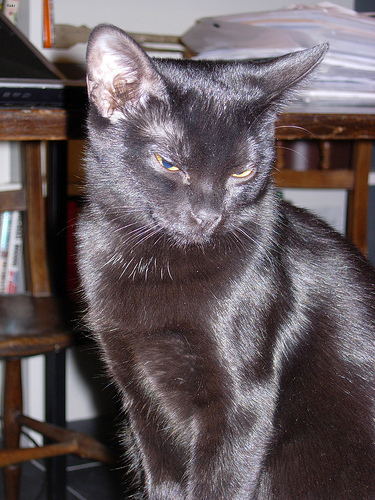

In [6]:
img = PILImage.create(files[0])
img

In [8]:
# Go through and do all processesing and relabelling
indices = np.arange(4)
for i in range(len(files)):

    # First grab the image, resize it and convery to numpy array
    img = np.array(PILImage.create(files[i]).resize((224,224)))

    # Grab data in cells, and save to list
    cells = []
    for row in range(2):
        for col in range(2):
            cells.append(img[row*112:(row+1)*112,col*112:(col+1)*112]) # No copy required, see NOTE
    
    # Get a permutation to shuffle the list by
    np.random.shuffle(indices)
    cells = np.array(cells)[indices] # NOTE: returns new, no copy above

    # Go back through, and update image
    for row in range(2):
        for col in range(2):
            img[row*112:(row+1)*112,col*112:(col+1)*112] = cells[row*2 + col]

    # Save filename as permutation used
    name = str(i) + '_' + '_'.join([str(c) for c in indices]) + '.jpg'

    # Convert back to image and overrite current file (with old name first)
    img = Image.fromarray(img)
    img.save(files[i])

    # Now rename with os in system, but first split string to get new name
    path_str = files[i].as_posix().split('/')
    new_path = '/'.join(path_str[:-1]) + '/' + name
    os.rename(files[i],new_path)

    # Finally, rename the path to match
    files[i] = files[i].with_name(name)

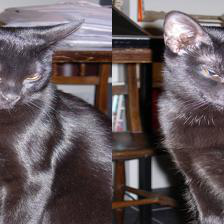

In [9]:
img = PILImage.create(files[0])
img

In [146]:
# Create function to unshuffle image given permutation
def unshuffle(x,mapping=None): # where x is just the Path object

    if mapping is None:
        # Get the name, has the label
        mapping = (x.name).split('_')[1:] # Exclude number
        mapping[-1] = mapping[-1][:-4] # get rid of .jpg for last
        mapping = np.array(mapping,np.int)

    # Grab image, and turn into a numpy array 
    if type(x) == pathlib.PosixPath:
        img = np.array(PILImage.create(x))
    else:
        img = np.array(x)

    # Go through, and add data where it goes in array
    cells = [None]*4
    for row in range(2):
        for col in range(2):
            cells[mapping[row*2 + col]] = img[row*112:(row+1)*112,col*112:(col+1)*112].copy() # Must copy

    # Second pass through, repopulate the img correctly
    for row in range(2):
        for col in range(2):
            img[row*112:(row+1)*112,col*112:(col+1)*112] = cells[row*2+col]
    
    # Turn back into image, and return
    return Image.fromarray(img)

In [71]:
# Real label function
def label_func(x):

    # Grab all the numbers in an array
    mapping = (x.name).split('_')[1:] # Exclude number
    mapping[-1] = mapping[-1][:-4] # get rid of .jpg for last
    mapping = np.array(mapping,np.int)

    # Return this normalized to sum to 1
    vals = np.array([-75,-25,25,75])
    retval = np.zeros(4)
    for i,idx in enumerate(mapping):
        retval[idx] = vals[i]
    return retval

In [72]:
pets = DataBlock(blocks = (ImageBlock,RegressionBlock(n_out=4)),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=label_func)
dls = pets.dataloaders(path/'images')

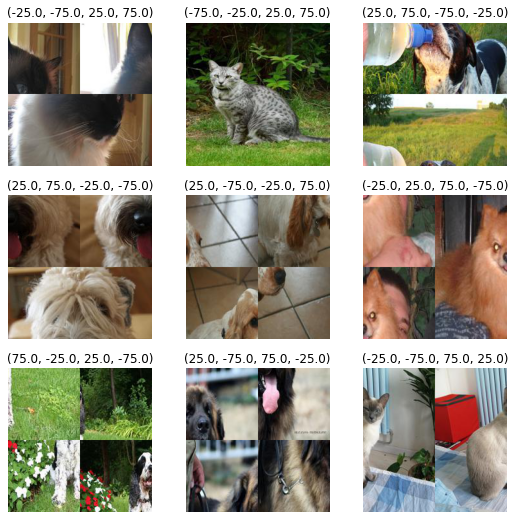

In [73]:
dls.show_batch()

In [221]:
#learn = cnn_learner(dls,resnet34)
#learn.fine_tune(3)

epoch,train_loss,valid_loss,time
0,125.333397,286.292358,00:33


epoch,train_loss,valid_loss,time
0,114.920609,306.142242,00:42
1,113.890839,250.328247,00:42
2,106.546494,235.559875,00:42


In [223]:
learn.predict(files[2])[2]

tensor([ 70.1737, -19.9095,  32.2550, -81.5158])

In [222]:
# Gets the accuracy of the validation set
correct = 0
total = len(dls.valid_ds)
for valid in dls.valid_ds:
    output = np.argsort(learn.predict(valid[0])[2])
    target = np.argsort(valid[1])
    correct += 1 if (output == target).all() else 0

print(correct/total*100)

90.39242219215156


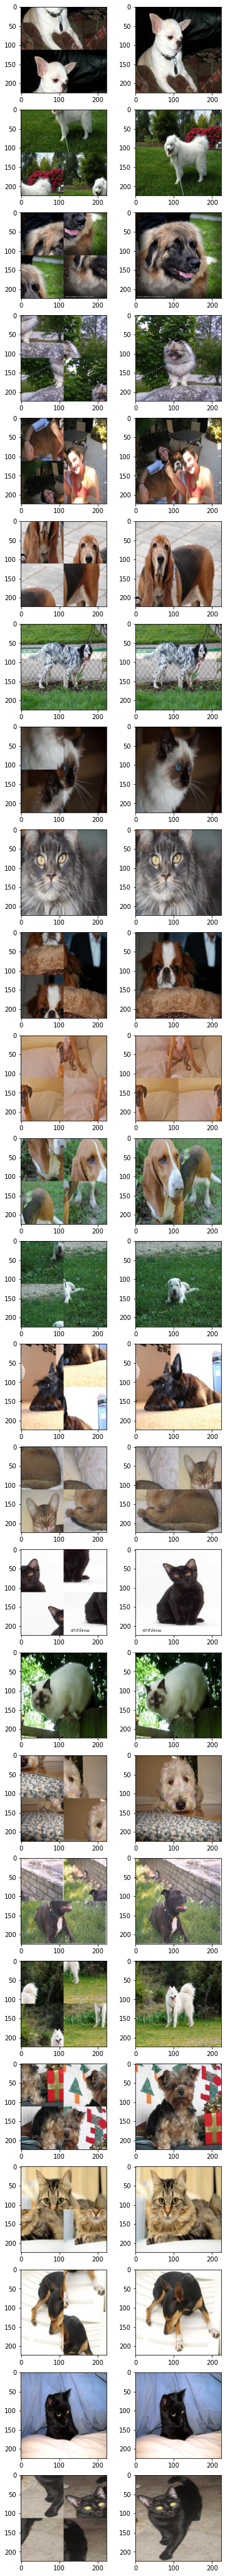

In [258]:
row,col = 25,2
fig,axs = subplots(row,col)
valid_subset = [dls.valid_ds[i][0] for i in random.sample(range(len(dls.valid_ds)),row)]
for i in range(row):
    input = valid_subset[i]
    output = unshuffle(input,np.argsort(learn2.predict(input)[2]))
    axs[i][0].imshow(input)
    axs[i][1].imshow(output)
plt.show()

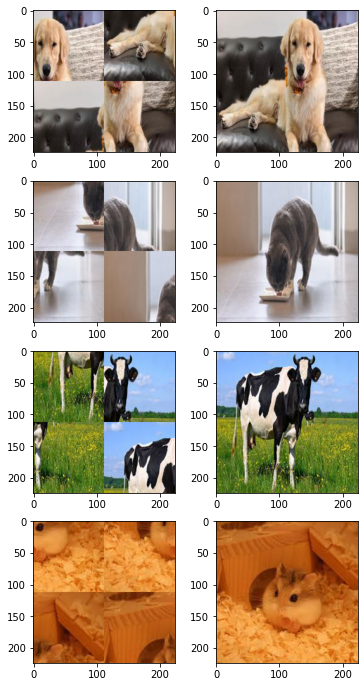

In [259]:
# Testing with random images
dog1 = PILImage.create('Dog1.jpg').resize((224,224))
cat1 = PILImage.create('Cat1.jpg').resize((224,224))
cow1 = PILImage.create('Cow1.jpg').resize((224,224))
rub1 = PILImage.create('Rub1.jpg').resize((224,224))

test_names = ['Dog1.jpg','Cat1.jpg','Cow1.jpg','Rub1.jpg']
test_images = [dog1,cat1,cow1,rub1]

# Scramble
indices = np.arange(4)
for i in range(len(test_images)):

    # First grab the image, resize it and convery to numpy array
    img = np.array(test_images[i])

    # Grab data in cells, and save to list
    cells = []
    for row in range(2):
        for col in range(2):
            cells.append(img[row*112:(row+1)*112,col*112:(col+1)*112]) # No copy required, see NOTE
    
    # Get a permutation to shuffle the list by
    np.random.shuffle(indices)
    cells = np.array(cells)[indices] # NOTE: returns new, no copy above

    # Go back through, and update image
    for row in range(2):
        for col in range(2):
            img[row*112:(row+1)*112,col*112:(col+1)*112] = cells[row*2 + col]

    # Convert back to image and overrite current file (with old name first)
    img = Image.fromarray(img)
    img.save(test_names[i])
    test_images[i] = PILImage.create(test_names[i])

# Now plot
row,col = len(test_images),2
fig,axs = subplots(row,col)
for i in range(row):
    input_name = test_names[i]
    input_image = test_images[i]
    output = unshuffle(input_image,np.argsort(learn2.predict(input_name)[2]))
    axs[i][0].imshow(input_image)
    axs[i][1].imshow(output)
plt.show()

In [236]:
type(dls.valid_ds[0][0])

fastai.vision.core.PILImage

In [256]:
learn.export(fname='Unscrambler.pkl',pickle_protocol=2)

In [257]:
learn2 = load_learner('Unscrambler.pkl')